In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

Function to randomly sample an action

In [2]:
def sample_action(policy, action , state):
    return np.random.choice(len(action), p=policy[state])

Function to generate a random episode

In [3]:
def generate_episode(policy, action, state):
    episode = [sample_action(policy, action, state[s]) for s in range(len(state))]
    
    return episode

Function that calculates the average value of the holdings in the portfolio

In [4]:
def average_price(price, holdings, holdings_list, price_list):
    holdings_list.append(holdings)
    price_list.append(price)
    
    init_price = price_list[0]
    init_holdings = holdings_list[0]
    
    delta_holdings = []

    
    if len(price_list) == 1:
        return price_list[0], holdings_list, price_list
    
    else:
        for x, y in zip(holdings_list, holdings_list[1:]):
            delta_holdings.append(y - x)
    
        avg_price =  ( np.dot(price_list[1:], delta_holdings) + init_price*init_holdings ) / (init_holdings + np.sum(delta_holdings))
        return avg_price, holdings_list, price_list

Function that determines total portfolio value

In [5]:
def portfolio_value(holdings, cash, price, holdings_list, price_list, action):
    if action == 0:
        cash -= price
        holdings += 1
  
    if action == 1:
        cash += price
        holdings -= 1
        
    if action == 2:
        pass
    
    avg_price, holdings_list, price_list = average_price(price, holdings, holdings_list, price_list)
    
    return avg_price, holdings_list, price_list, holdings, cash

Function that determines the reward. It outputs a list that contains the reward at each decision epoch in the episode.

In [6]:
def generate_returns(episode, price, cash_s1, holdings_s1, price_list, holdings_list, gamma):
    p_v = []
    avg_price = price_list[0]
    
    for s in range(len(episode)):
        
        avg_price, holdings_list, price_list, holdings_s1, cash_s1 = portfolio_value(holdings_s1, cash_s1, price[s], holdings_list, price_list, episode[s])
#         print(avg_price, holdings_list, price_list, holdings_s1, cash_s1)
        
        #store portfolio values in list at each time step
        p_v.append(cash_s1 + price[s]*holdings_s1)
    
    rew = []
    for x,y in zip(p_v, p_v[1:]):
        rew.append(y - x)
    rew.append(0)
        
    gamma_list = np.array([gamma**i for i in range(len(episode))])
#     print(p_v)
    return np.dot(gamma_list,rew), rew

Helper function that calculates total returns of the portfolio

In [7]:
def pf_returns(iterations, alpha, gamma, price, price_list, cash_s1, 
               holdings_s1, holdings_list, state, action, features, episode):
    p_v = []
    avg_price = price_list[0]
    
    for s in range(len(episode)):
        
        avg_price, holdings_list, price_list, holdings_s1, cash_s1 = portfolio_value(holdings_s1, cash_s1, price[s], holdings_list, price_list, episode[s])
#         print(avg_price, holdings_list, price_list, holdings_s1, cash_s1)       
        #store portfolio values in list at each time step
        p_v.append(cash_s1 + price[s]*holdings_s1)
        
    return p_v

Function that builds features. It outputs a list, with each element containing a sublist that holds the prices for three consecutive decision epochs. This is used to create x(s,a)

In [8]:
def build_features(n, price):
    features = []
    
    features = []
    for i in range((n-1) ,len(price)):
        features.append( price[i-(n-1):i+1] )

    #initialize first (n-1) features as the initial price
    for i in range(n-1):
        features.insert(0, np.array([price[0],price[0],price[0]]) )
        
    return features

Function to create x(s,a) for momentum investing using the features built using build_features function.

In [9]:
#Features for Momentum Investing
def feature_actionValue(features, s, a):
    x_sa = []

    #if buying
    if a==0:
        if features[s][-1] > np.mean(features[s]):
            x_sa.append( np.abs(features[s][-1] - np.mean(features[s]))*-1 )

        else:
            x_sa.append( np.abs(features[s][-1] - np.mean(features[s])) )

        return np.array(x_sa)

    #if selling
    if a==1:
        if features[s][-1] > np.mean(features[s]):
            x_sa.append( np.abs(features[s][-1] - np.mean(features[s])) )

        else:
            x_sa.append( np.abs(features[s][-1] - np.mean(features[s]))*-1 )

        return np.array(x_sa)

Function to create x(s,a) for "buy the dip" investing using the features built using build_features function.

In [10]:
#Features for Buying the Dip
# def feature_actionValue(features, s, a):
#     x_sa = []

#     #if buying
#     if a==0:
#         if features[s][-1] > np.mean(features[s]):
#             x_sa.append( np.abs(features[s][-1] - np.mean(features[s])) )

#         else:
#             x_sa.append( np.abs(features[s][-1] - np.mean(features[s]))*(-1) )

#         return np.array(x_sa)

#     #if selling
#     if a==1:
#         if features[s][-1] > np.mean(features[s]):
#             x_sa.append( np.abs(features[s][-1] - np.mean(features[s]))*(-1) )

#         else:
#             x_sa.append( np.abs(features[s][-1] - np.mean(features[s])) )

#         return np.array(x_sa)

Implementation of linear VFA Policy Evaluation and epsilon-greedy policy improvement using pseudocode in lecture slides.

In [11]:
def MC_linearVFA_2(iterations, alpha, gamma, price, cash_s1, holdings_s1, state, action, features):
    
    nS = len(state)
    nA = len(action)
    
    policy = np.ones((nS,nA))/nA  # initially all actions are equally likely
    epsilon = 1
    eps_final = 0.001
    decay_rate = (epsilon - eps_final)/iterations
    
    #only considering 1 features
    weight = np.array([0]*1)
    
    for k in range(1,iterations):
#         print(k)
        episode = generate_episode(policy, action, state)
        holdings_list = [1000]
        price_list = [price[0]]
        
        _, rw = generate_returns(episode, price, cash_s1, holdings_s1, price_list, holdings_list, gamma)
        
        for s in range(len(episode)):
            all_acts = [0,1]
            a = episode[s]
            x_sa = feature_actionValue(features,s,a)
            G = sum(rw[s:])
            
            
            Q_value = np.dot(x_sa, weight)
            weight = weight + alpha*(G - Q_value)*x_sa
            
            all_acts.remove(a)
            other_a = all_acts[0]
            
            x_sa_other = feature_actionValue(features, s, other_a)
            Q_other = np.dot(x_sa_other, weight)

            
            if Q_value > Q_other:
                policy[s][a] = epsilon/nA + (1 - epsilon)
                policy[s][other_a] = epsilon/nA
        
            if Q_other > Q_value:
                policy[s][other_a] = epsilon/nA + (1 - epsilon)
                policy[s][a] = epsilon/nA
            
        epsilon -= decay_rate
    
    det_pol = np.argmax(policy, axis = 1)
    
    return det_pol, weight, policy

extract stock price data from yfinance library, and setting model parameters.

In [17]:
aapl = yf.download('HD','2019-01-01','2019-12-31')

price = list(np.round(list(aapl["Close"]),2))
action = [0,1]
state = np.arange(len(price))

iterations = 2000
gamma = 0.9
alpha = 0.05
holdings_list = [1000]
holdings_s1 = holdings_list[0]
price_list = [price[0]]
cash_s1 = 10000

features = build_features(3,price)

opt_pol, wgt, pol = MC_linearVFA_2(iterations, alpha, gamma, price, cash_s1, holdings_s1, state, action, features)

[*********************100%***********************]  1 of 1 completed


Printing the total returns

In [18]:
returns = pf_returns(iterations, alpha, gamma, price, price_list, cash_s1, holdings_s1, holdings_list, state, action, features, opt_pol)[-1]

print("The total returns is $",returns)

The total returns is $ 228130.75


Plotting the results for a subset of the time horizon

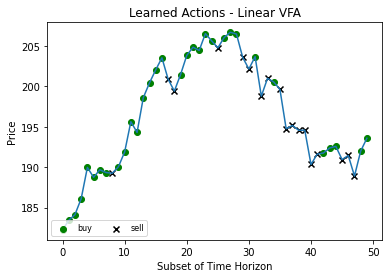

In [19]:
import matplotlib.pyplot as plt

opt_pol = np.array(opt_pol[50:100])
price = np.array(price[50:100])

ind_zero  = np.where(opt_pol==0)[0]
ind_ones  = np.where(opt_pol==1)[0]

plt.plot(price)
plt.title('Learned Actions - Linear VFA')
plt.xlabel("Subset of Time Horizon")
plt.ylabel("Price")
buy = plt.scatter(ind_zero,price[ind_zero], marker='o', c='green')
sell = plt.scatter(ind_ones, price[ind_ones], marker='x', c='k')

plt.legend((buy,sell),
           ('buy','sell'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()